In [1]:
import numpy as np
import scipy.signal as sg
from pathlib import Path
import scipy.stats as ss
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

In [2]:
fs_bold = 1 / 0.72 # Hz sampling rate

In [3]:
import argparse, json, os, numpy as np, torch
from pathlib import Path
import matplotlib.pyplot as plt

from whobpyt.data_loader import BOLDDataLoader, DEVICE
from simulators.rww_simulator import RWWSubjectSimulator
from whobpyt.custom_cost_RWW import CostsRWW
from whobpyt.modelfitting import Model_fitting
from whobpyt.utils.fc_tools import bold_to_fc
from whobpyt.utils.plot_fc_windows import plot_fc_grid
from whobpyt.utils.plotter import heatmap_fc   

data_root = "/vol/bitbucket/ank121/fyp/HCP Data"
chunk_length = 100
lr = 0.1
epochs = 30
step = 0.05
g = 1000.0
lambda_rate, lambda_spec, lambda_disp = 0.05, 0.05, 0.03

fmri = os.path.join(data_root, "BOLD Timeseries HCP.mat")
scdir = os.path.join(data_root, "distance_matrices")
dist  = os.path.join(data_root, "schaefer100_dist.npy")

loader = BOLDDataLoader(fmri, scdir, dist, chunk_length)
loader._split_into_chunks()

subj = 18
ts_emp = loader.all_bold[subj]
fc_emp = bold_to_fc(ts_emp)

Using DEVICE = cuda
[DataLoader] Loaded 100 subjects.
[DataLoader] Created 1100 chunks (chunk length = 100).


In [ ]:

print(f"[+] chunk={chunk_length} lr={lr} step={step} g={g}")
label = f"sub{subj:03d}_chunk{chunk}_gEE{1}_gEI{1}"
sc = loader.get_subject_connectome(subj, norm=True)
sim = RWWSubjectSimulator(sc, sc.shape[0], TP_per_window=chunk_length, fit_g_EE=True, fit_g_IE=True, fit_g_EI=False, 
                        use_bifurcation=False, step_size=step, g_init=g, use_fic=False)
sim.model.to(DEVICE)


train_window_length = 900
emp_FCs = loader.train_fc_windows(subj, win_len=train_window_length)
train_num_windows = train_window_length // chunk_length

cost = CostsRWW(sim.model,
                use_rate_reg = lambda_rate > 0, lambda_rate = lambda_rate,
                use_spec_reg = lambda_spec > 0, lambda_spec = lambda_spec,
                use_disp_reg = lambda_disp > 0, lambda_disp = lambda_disp,
                verbose=False)
fitter = Model_fitting(sim.model, cost, device=DEVICE)
fitter.train(u=0, empFcs=emp_FCs, num_epochs=epochs,
            num_windows=train_num_windows, learningrate=lr, early_stopping=True)

test_num_windows = ts_emp.shape[1] // chunk_length
ts_sim, fc_sim = sim.simulate(u=0, num_windows=test_num_windows, base_window_num=10)
tri = np.tril_indices_from(fc_sim, k=-1)
r = np.corrcoef(fc_sim[tri], fc_emp[tri])[0, 1]

print(f"- Entire TS FC-corr test = {r:.3f} -")


In [11]:
SAVE_DIR = Path("simulated_outputs"); SAVE_DIR.mkdir(parents=True, exist_ok=True)
label = f"sub{subj:03d}"
# np.save(SAVE_DIR / f"{label}.npy", ts_sim)

ts_sim = np.load(SAVE_DIR / f"{label}.npy")
fc_sim = bold_to_fc(ts_sim)

In [5]:
def fcd_matrix(ts, wind=60, step=30):
    """ Sliding-window FCD (Pearson's correlation of FC-vectors)  """
    N, T = ts.shape
    idx = range(0, T - wind + 1, step)
    fc_vecs = []
    tri = np.tril_indices(N, -1)
    for s in idx:
        fc = np.corrcoef(ts[:, s:s+wind])
        fc_vecs.append(fc[tri])
    fc_vecs = np.stack(fc_vecs)                # (W, E)
    F = np.corrcoef(fc_vecs)
    return F

def compare_fcd_ks(ts_emp, ts_sim, wind=60, step=30, ax=None):
    """ Kolmogorov-Smirnov distance betweent wo FCD matrices' off-diagonal distributions """
    F_emp = fcd_matrix(ts_emp[:, :ts_sim.shape[1]], wind, step)
    F_sim = fcd_matrix(ts_sim, wind, step)
    tri = np.triu_indices_from(F_emp, k=1)
    ks_d = ss.ks_2samp(F_emp[tri], F_sim[tri]).statistic
    
    if ax is not None:
        ax.hist(F_emp[tri], bins=40, alpha=.4, label='emp')
        ax.hist(F_sim[tri], bins=40, alpha=.4, label='sim')
        ax.set_title(f"FCD hist - KS {ks_d:.3f}"); ax.legend()
    return ks_d

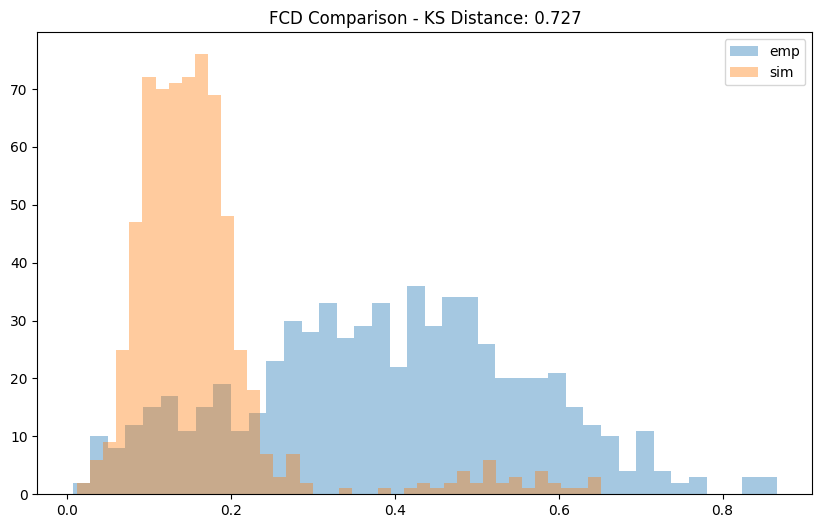

Kolmogorov-Smirnov distance between FCD distributions: 0.727


In [6]:

fig, ax = plt.subplots(figsize=(10, 6))
ks_distance = compare_fcd_ks(ts_emp, ts_sim, wind=60, step=30, ax=ax)
plt.title(f"FCD Comparison - KS Distance: {ks_distance:.3f}")
plt.show()

assert 0 <= ks_distance <= 1, "KS distance outside expected range (0-1)"

print(f"Kolmogorov-Smirnov distance between FCD distributions: {ks_distance:.3f}")


In [33]:
## State dwell-times - expect to see to see multi-state transitions

from sklearn.cluster import KMeans

def fc_vectors(ts, wind=60, step=60):
    N, T = ts.shape
    tri = np.tril_indices(N, -1)
    vecs = []
    for s in range(0, T - wind + 1, step):
        fc = np.corrcoef(ts[:, s:s+wind])
        vecs.append(fc[tri])
    return np.array(vecs)    # (W, E)

def state_dwell_and_transition(ts_emp, ts_sim, n_states=5, wind=60):
    # Get non-overlapping vector flattened FC matrices
    V_emp = fc_vectors(ts_emp[:, :ts_sim.shape[1]], wind, wind)
    V_sim = fc_vectors(ts_sim, wind, wind)

    km = KMeans(n_clusters=n_states, n_init=50, random_state=0).fit(V_emp)
    lab_emp = km.predict(V_emp)
    lab_sim = km.predict(V_sim)

    print(lab_emp)
    print(lab_sim)

    def dwell(labels, k):
        counts = np.bincount(labels, minlength=k)
        return counts / counts.sum()
    dwell_emp = dwell(lab_emp, n_states)
    dwell_sim = dwell(lab_sim, n_states)
    dwell_diff = np.abs(dwell_emp - dwell_sim).sum()
    
    def trans_mat(labels, k):
        T = np.ones((k, k))
        for a, b in zip(labels[:-1], labels[1:]):
            T[a, b] += 1
        print(T)
        T = T / (T.sum(axis=1, keepdims=True))
        return T
    P_emp = trans_mat(lab_emp, n_states)
    P_sim = trans_mat(lab_sim, n_states)
    print(P_emp.shape)
    print(P_emp)
    print(P_sim.shape)
    print(P_sim)
    transition_norm = np.linalg.norm(P_emp - P_sim, ord='fro')
    
    return dwell_diff, transition_norm


In [34]:
dw, tr = state_dwell_and_transition(ts_emp, ts_sim)
print(f"dwell L1 = {dw:.2f}, ΔP Fro = {tr:.2f}")
assert dw >= 0 and tr >= 0

[1 1 1 4 4 1 4 1 4 4 4 4 4 1 4 4 3 4 3]
[2 2 3 4 4 2 4 1 2 2 1 1 3 3 4 1 1 1 0]
[[1. 1. 1. 1. 1.]
 [1. 3. 1. 1. 5.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 2.]
 [1. 4. 1. 3. 7.]]
[[1. 1. 1. 1. 1.]
 [2. 4. 2. 2. 1.]
 [1. 2. 3. 2. 2.]
 [1. 1. 1. 2. 3.]
 [1. 3. 2. 1. 2.]]
(5, 5)
[[0.2        0.2        0.2        0.2        0.2       ]
 [0.09090909 0.27272727 0.09090909 0.09090909 0.45454545]
 [0.2        0.2        0.2        0.2        0.2       ]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.33333333]
 [0.0625     0.25       0.0625     0.1875     0.4375    ]]
(5, 5)
[[0.2        0.2        0.2        0.2        0.2       ]
 [0.18181818 0.36363636 0.18181818 0.18181818 0.09090909]
 [0.1        0.2        0.3        0.2        0.2       ]
 [0.125      0.125      0.125      0.25       0.375     ]
 [0.11111111 0.33333333 0.22222222 0.11111111 0.22222222]]
dwell L1 = 0.74, ΔP Fro = 0.53


In [7]:
def spectral_slope(ts, fs=1/0.72, f_lo=0.02, f_hi=0.10):
    """ Average PSD across regions, regress log-power on log-freq.
        Returns +β so 1/f^β 
    """
    N, T = ts.shape
    # Welch across entire run
    f, Pxx = sg.welch(ts, fs=fs, nperseg=T//4, axis=1)
    mask = (f >= f_lo) & (f <= f_hi)
    x = np.log(f[mask]); y = np.log(Pxx[:, mask].mean(axis=0))
    beta, _ = np.polyfit(x, y, 1)
    return -beta      # make positive
    
def spectral_slope_error(ts_emp, ts_sim):
    beta_emp = spectral_slope(ts_emp)
    beta_sim = spectral_slope(ts_sim[:, :ts_emp.shape[1]])
    return abs(beta_emp - beta_sim), beta_emp, beta_sim


In [8]:
err, b_e, b_s = spectral_slope_error(ts_emp, ts_sim)
print(f"β_emp={b_e:.2f}, β_sim={b_s:.2f}, |Δ|={err:.2f}")
assert err < 2, "Slope difference seems too large – check units?"


β_emp=2.61, β_sim=1.11, |Δ|=1.50


In [9]:
def graph_metrics(fc, k_prop=.10):
    """
    Threshold at top k_prop edges, return dict of metrics.
    """
    fc = fc.copy()
    np.fill_diagonal(fc, 0)
    # proportional threshold
    thr = np.quantile(fc, 1 - k_prop)
    adj = (fc * (fc >= thr)).astype(float)
    G   = nx.from_numpy_array(adj)
    
    clust = np.mean(list(nx.clustering(G, weight='weight').values()))
    modularity = nx.algorithms.community.modularity(G, nx.algorithms.community.louvain_communities(G, seed=0), weight='weight')
    eff_glob = nx.global_efficiency(G)
    # small-worldness σ ≈ (C/Crand)/(L/Lrand)
    n_rand = 10
    Crand, Lrand = [], []
    for _ in range(n_rand):
        Gr = nx.algorithms.smallworld.random_reference(G, nswap=10*G.number_of_edges())
        Crand.append(np.mean(list(nx.clustering(Gr).values())))
        Lrand.append(nx.average_shortest_path_length(Gr))
    C  = clust
    L  = nx.average_shortest_path_length(G)
    sigma = (C/np.mean(Crand)) / (L/np.mean(Lrand))
    
    return dict(C=C, Q=modularity, Eglob=eff_glob, sigma=sigma)

def graph_static_error(fc_emp, fc_sim):
    m_emp = graph_metrics(fc_emp)
    m_sim = graph_metrics(fc_sim)
    print(m_emp)
    print(m_sim)
    return {k: abs(m_emp[k]-m_sim[k]) for k in m_emp.keys()}, m_emp, m_sim


In [12]:
errs, *_ = graph_static_error(fc_emp, fc_sim)
print("Graph metric |Δ|", errs)


TypeError: random_reference() got an unexpected keyword argument 'nswap'

In [15]:
def kuramoto_order(ts, band=(0.04, 0.07), fs=1/0.72):
    """
    Band-pass ➜ phase ➜ R(t)
    """
    b, a = sg.butter(3, np.array(band)/(fs/2), btype='band')
    phased = np.angle(sg.hilbert(sg.filtfilt(b, a, ts, axis=1)))
    R = np.abs(np.mean(np.exp(1j*phased), axis=0))
    return R

def metastability_error(ts_emp, ts_sim):
    R_emp = kuramoto_order(ts_emp[:, :ts_sim.shape[1]])
    R_sim = kuramoto_order(ts_sim)
    return abs(R_emp.std() - R_sim.std()), R_emp.std(), R_sim.std()

metastability_error(ts_emp, ts_sim)

(0.04325888001190814, 0.15987768597874605, 0.11661880596683791)

In [18]:
ts_rand = np.random.rand(*ts_emp.shape)
print(ts_rand.shape)
print(metastability_error(ts_emp, ts_rand))
print(metastability_error(ts_sim, ts_rand))

(100, 1189)
(0.0, 0.16769964672028953, 0.16769964672028953)
(0.06761153245753865, 0.11661880596683791, 0.04900727350929925)
